In [34]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet import preprocess_input

In [35]:
Train_data = 'C:/Users/gaura/Music/Ashwini Mam Project/pythonfiles/Resnet50/data/'
Test_data = 'C:/Users/gaura/Music/Ashwini Mam Project/pythonfiles/Resnet50/test/'

train_data_df = pd.DataFrame(columns=['Image_path','Label'])
test_data_df = pd.DataFrame(columns=['Image_path'])

In [36]:
def load_dataframe(DF,path):
    labels_files = os.listdir(path)
    image_paths = []
    labels = []
    for file in labels_files:
        path_file = path + file +'\\'
        list_files = os.listdir(path_file)
        for image_path in list_files:
            image_paths.append(path_file + image_path)
            labels.append(file)
    DF['Image_path'] = image_paths
    DF['Label'] = labels
    return(DF)

In [37]:
train_data_df = load_dataframe(train_data_df,Train_data)
test_data_df = load_dataframe(test_data_df,Test_data)

train_data_df = shuffle(train_data_df)
test_data_df = shuffle(test_data_df)

encoder = LabelEncoder()
train_data_df['Label'] = encoder.fit_transform(train_data_df['Label'])
test_data_df['Label'] = encoder.fit_transform(test_data_df['Label'])

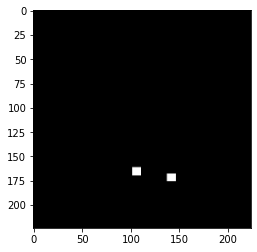

(224, 224, 3)

In [38]:
import cv2
def load_image(path):
    img = cv2.imread(path,1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    img = cv2.resize(img,(224,224))
    return img

img = load_image(train_data_df['Image_path'][0])
fig,ax = plt.subplots(1)
ax.imshow(img)
plt.show()

img.shape

In [39]:
x_train = []
for image_path in train_data_df['Image_path'] :
    img = load_image(image_path)
    img = preprocess_input(np.array(img, dtype=np.float32))
    x_train.append(img)
x_train = np.array(x_train)

In [40]:
x_test = []
for image_path in test_data_df['Image_path'] :
    img = load_image(image_path)
    img = preprocess_input(np.array(img, dtype=np.float32))
    x_test.append(img)
x_test = np.array(x_test)

In [41]:
y_train = train_data_df['Label'].to_list()
y_test = test_data_df['Label'].to_list()

In [42]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train,num_classes=3)
y_train = y_train.reshape(y_train.shape[0],1,1,y_train.shape[1])
y_test = to_categorical(y_test,num_classes=3)
y_test = y_test.reshape(y_test.shape[0],1,1,y_test.shape[1])

In [43]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Reshape, UpSampling2D, Concatenate, Conv2D,Conv2DTranspose,Dropout,Dense,MaxPool2D
from tensorflow.keras.models import Model

def create_model(trainable=True):
    model = ResNet50(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable    

    x =  model.output
    x = Conv2D(1024, kernel_size=3,padding ='same',activation="relu")(x)
    x = MaxPool2D()(x)
    x = Conv2D(512, kernel_size=3,padding ='same',activation="relu")(x)
    x = MaxPool2D()(x)
    x = Dense(1000,activation = 'relu')(x)
    x = Dense(3,activation = 'softmax')(x)
    return(Model(inputs = model.input,outputs = x))

model = create_model(False)

In [44]:
import tensorflow
Optimizer = tensorflow.keras.optimizers.Adam(learning_rate = 1e-5,beta_1 = 0.9,decay = 1e-5)

model.compile(optimizer= Optimizer,loss= 'categorical_crossentropy',metrics= 'accuracy')

In [47]:
# # Model Checkpoint
# ModelCheckpoint = tensorflow.keras.callbacks.ModelCheckpoint("pneu_1-{val_loss:.3f}.h5",monitor='val_loss',save_best_only= True,save_weights_only=True)

# ReduceLOR =  tensorflow.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor =0.1,patience=2,min_lr=1e-5)

In [48]:
# model.fit(x_train,y_train,epochs = 10,batch_size = 1,validation_data = (x_test,y_test),callbacks=[ModelCheckpoint,ReduceLOR])
model_history = model.fit(x_train,y_train, validation_data = (x_test,y_test),epochs=10,batch_size = 1)

Epoch 1/10
2093/2093 [==============================] - 963s 460ms/step - loss: 0.5776 - accuracy: 0.7582 - val_loss: 0.1650 - val_accuracy: 0.9524
Epoch 2/10
2093/2093 [==============================] - 906s 433ms/step - loss: 0.3262 - accuracy: 0.8763 - val_loss: 0.0817 - val_accuracy: 0.9524
Epoch 3/10
2093/2093 [==============================] - 754s 360ms/step - loss: 0.2422 - accuracy: 0.9078 - val_loss: 0.0584 - val_accuracy: 1.0000
Epoch 4/10
2093/2093 [==============================] - 467s 223ms/step - loss: 0.1729 - accuracy: 0.9393 - val_loss: 0.0336 - val_accuracy: 1.0000
Epoch 5/10
2093/2093 [==============================] - 467s 223ms/step - loss: 0.1308 - accuracy: 0.9513 - val_loss: 0.0340 - val_accuracy: 1.0000
Epoch 6/10
2093/2093 [==============================] - 544s 260ms/step - loss: 0.1001 - accuracy: 0.9627 - val_loss: 0.0861 - val_accuracy: 0.9524
Epoch 7/10
2093/2093 [==============================] - 525s 251ms/step - loss: 0.0945 - accuracy: 0.9656 - val_

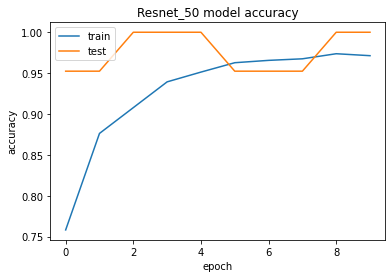

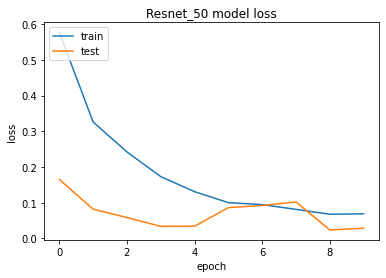

In [49]:
def plotModelAccuracy(history, modelname):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])

    plt.title(modelname+' model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.title(modelname+' model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

plotModelAccuracy(model_history, 'Resnet_50')

In [50]:
# encoder.classes_[np.argmax(pred)]
# encoder.classes_[np.argmax(y_train[300][0][0])]

# import os
# import tensorflow as tf
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# from sklearn.utils import shuffle
# import cv2
# import matplotlib.pyplot as plt
# from tensorflow.keras.applications.mobilenet import preprocess_input

# def predict(image):
#     _model = create_model(True)
#     _model.load_weights('pneu_1-0.733.h5')
#     image = cv2.resize(image, (224,224))
#     pred = _model.predict(np.array(image).reshape(1,224,224,3))
#     lab = encoder.classes_[np.argmax(pred)]
#     return(lab)

# # image = cv2.imread('D:\\Omkar Project\\chest_xray\\train\\normal\\IM-0191-0001.jpeg', 1)
# # predict(image)

# # converter = tf.lite.TFLiteConverter.from_keras_model(_model) # path to the SavedModel directory
# # tflite_model = converter.convert()
# # with open('model.tflite', 'wb') as f:
# #     f.write(tflite_model)